In [42]:
import os
DATA_DIR = './data/animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [43]:
print(os.listdir(DATA_DIR+'/images')[:10])

['14020_2006.jpg', '13333_2005.jpg', '60934_2018.jpg', '49439_2015.jpg', '45935_2014.jpg', '48835_2014.jpg', '24253_2008.jpg', '54760_2016.jpg', '7697_2004.jpg', '54228_2016.jpg']


In [44]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [45]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [46]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [47]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
#image = ((image * std) + mean) --> transform image back in [0 1] range
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [49]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

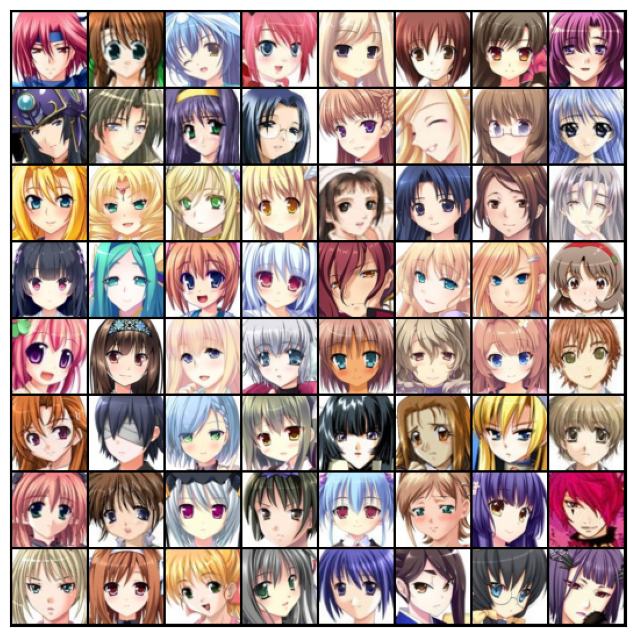

In [50]:
show_batch(train_dl)

In [51]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [52]:
device = get_default_device()
device

device(type='cuda')

In [53]:
train_dl = DeviceDataLoader(train_dl, device)

In [54]:
import torch.nn as nn

In [55]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

   

    # in: 64 x 32 x 32
    #add appropriate NN layers (conv2d, batch norm and leaky relu)
    nn.Conv2d(64,128,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    # in: 128 x 16 x 16
    nn.Conv2d(128,256,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    # in: 256 x 8 x 8
    nn.Conv2d(256,512,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    #Add only conv2d layer here to output 1x1x1 value
    nn.Conv2d(512,1,kernel_size=4, stride=2, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [56]:
discriminator = to_device(discriminator, device)

In [57]:
latent_size = 128

In [58]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


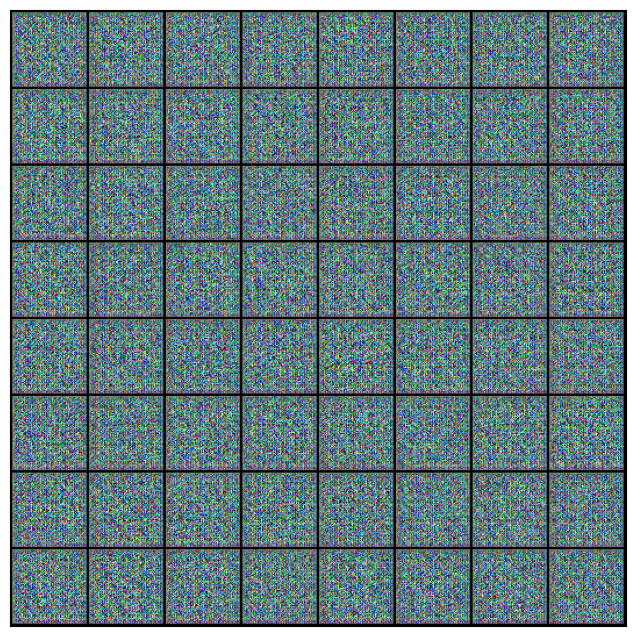

In [59]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [60]:
generator = to_device(generator, device)

In [61]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images.detach())
    fake_targets = torch.zeros(batch_size, 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [62]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [63]:
from torchvision.utils import save_image

In [64]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [65]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [66]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998853..0.9999063].


Saving generated-images-0000.png


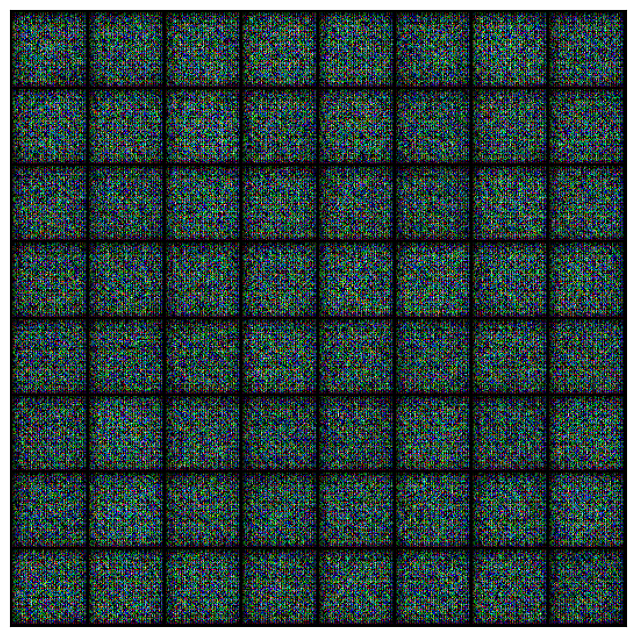

In [67]:
save_samples(0, fixed_latent)

In [68]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [69]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.to(device)
            
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            # Train generator
            loss_g = train_generator(opt_g)
            
            
        # Record losses & scores
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score) 
        
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [70]:
lr = 0.0002
epochs = 25

In [71]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 5.5619, loss_d: 0.2475, real_score: 0.9509, fake_score: 0.1569
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 10.0089, loss_d: 0.8674, real_score: 0.9764, fake_score: 0.5194
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 5.5498, loss_d: 0.1731, real_score: 0.9329, fake_score: 0.0911
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 6.5508, loss_d: 0.3198, real_score: 0.8824, fake_score: 0.1487
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 6.7670, loss_d: 0.0202, real_score: 0.9834, fake_score: 0.0023
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 6.5788, loss_d: 0.0676, real_score: 0.9853, fake_score: 0.0494
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 5.0307, loss_d: 0.1336, real_score: 0.9133, fake_score: 0.0286
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 8.0450, loss_d: 0.0219, real_score: 0.9952, fake_score: 0.0167
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 8.1467, loss_d: 0.7969, real_score: 0.5796, fake_score: 0.0001
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 5.6984, loss_d: 0.0468, real_score: 0.9792, fake_score: 0.0230
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 8.4400, loss_d: 0.0149, real_score: 0.9877, fake_score: 0.0007
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 4.9689, loss_d: 0.1324, real_score: 0.9311, fake_score: 0.0246
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.9312, loss_d: 0.1192, real_score: 0.9537, fake_score: 0.0451
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 7.1784, loss_d: 0.1467, real_score: 0.9577, fake_score: 0.0829
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 12.0110, loss_d: 0.2054, real_score: 0.9998, fake_score: 0.1614
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 9.0705, loss_d: 0.1072, real_score: 0.9957, fake_score: 0.0901
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 7.7460, loss_d: 0.0742, real_score: 0.9414, fake_score: 0.0029
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 8.0236, loss_d: 0.0316, real_score: 0.9753, fake_score: 0.0049
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 8.8434, loss_d: 0.0056, real_score: 0.9983, fake_score: 0.0038
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 7.2096, loss_d: 0.0727, real_score: 0.9777, fake_score: 0.0455
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 13.4681, loss_d: 0.0076, real_score: 0.9990, fake_score: 0.0060
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 17.7404, loss_d: 0.3792, real_score: 0.8216, fake_score: 0.0000
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 17.3202, loss_d: 0.0537, real_score: 0.9842, fake_score: 0.0335
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 21.1510, loss_d: 0.0648, real_score: 0.9579, fake_score: 0.0047
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.6447, loss_d: 0.0477, real_score: 0.9768, fake_score: 0.0223
Saving generated-images-0025.png


In [72]:
losses_g, losses_d, real_scores, fake_scores = history

In [73]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [74]:
from IPython.display import Image

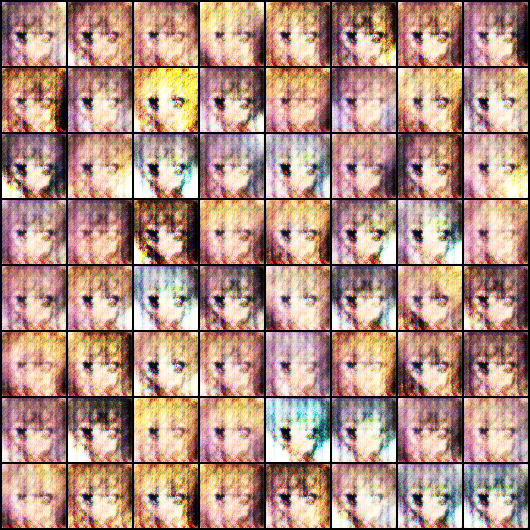

In [75]:
Image('./generated/generated-images-0001.png')

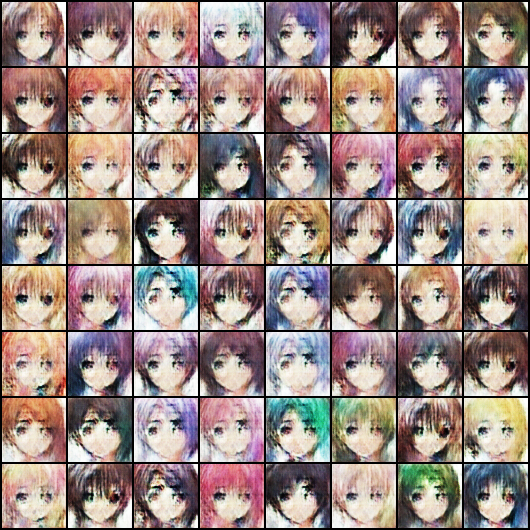

In [76]:
Image('./generated/generated-images-0005.png')

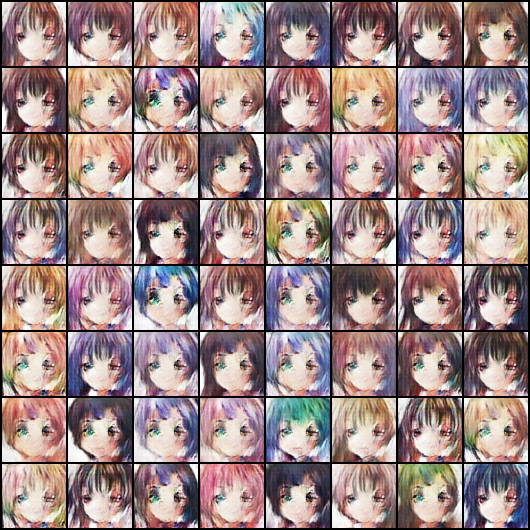

In [77]:
Image('./generated/generated-images-0010.png')

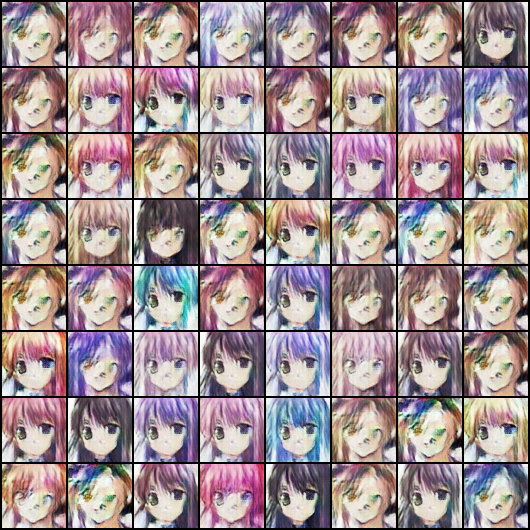

In [78]:
Image('./generated/generated-images-0025.png')

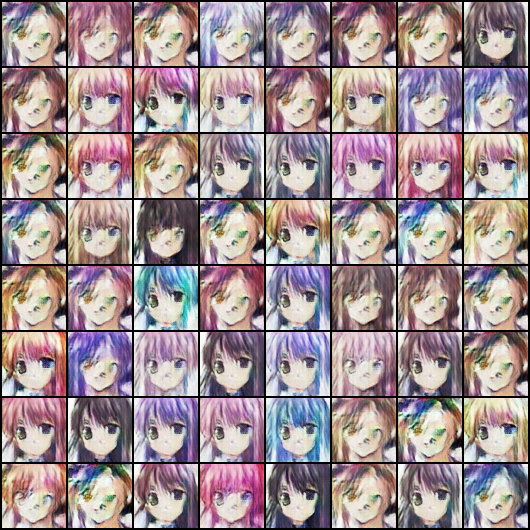

In [79]:
Image('./generated/generated-images-0025.png')

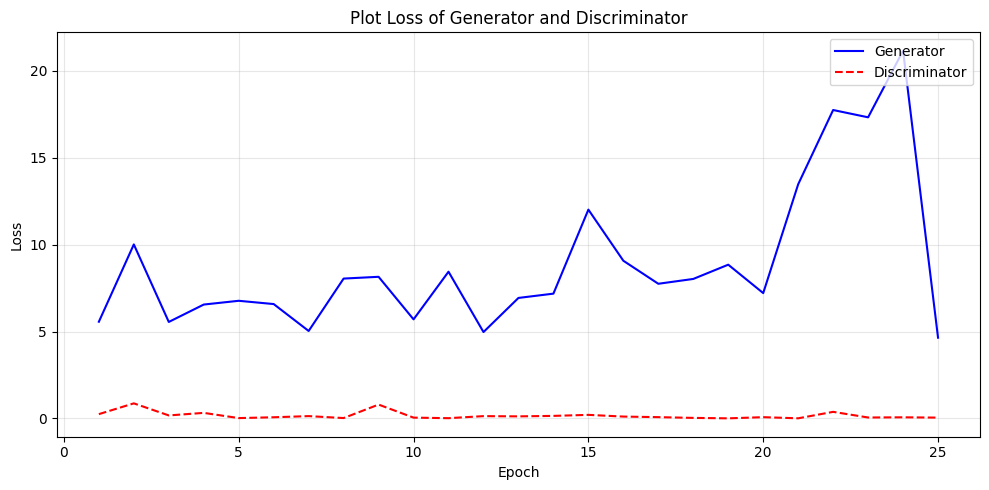

In [80]:
#Plot Loss of Generator and Discriminator
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Plot Loss of Generator and Discriminator")
ax.plot(range(1, len(losses_g) + 1), losses_g, linestyle='-', marker='', color='blue', label='Generator')
ax.plot(range(1, len(losses_d) + 1), losses_d, linestyle='--', marker='', color='red', label='Discriminator')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc="upper right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


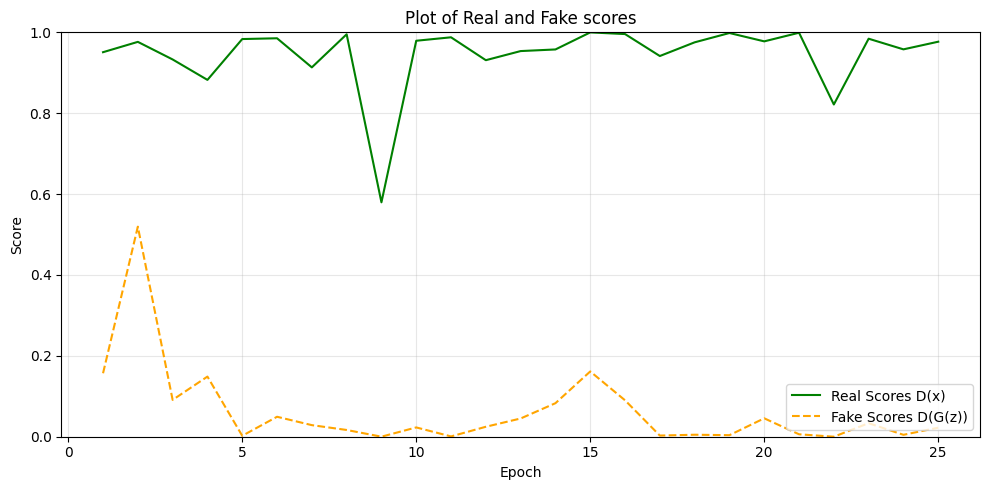

In [81]:
#Plot of Real and Fake scores
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Plot of Real and Fake scores")
ax.plot(range(1, len(real_scores) + 1), real_scores, linestyle='-', color='green', label='Real Scores D(x)')
ax.plot(range(1, len(fake_scores) + 1), fake_scores, linestyle='--', color='orange', label='Fake Scores D(G(z))')
ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
